# CCDC - Submission Model Training

### LIBRARIES

In [1]:
%%capture
!pip install pandas_path pytorch_lightning cloudpathlib loguru typer
!pip install --upgrade pandas==1.2.4
!pip install albumentations

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import shutil

import rasterio
import pyproj
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas_path import path  # noqa
from pathlib import Path
from PIL import Image
import pytorch_lightning as pl
import torch
import albumentations

### DATA

In [3]:
DATA_DIR = Path("/driven-data/cloud-cover")
TRAIN_FEATURES = DATA_DIR / "train_features"
TRAIN_LABELS = DATA_DIR / "train_labels"

assert TRAIN_FEATURES.exists()

In [4]:
BANDS = ["B02", "B03", "B04", "B08"]

#### Metadata

In [5]:
train_meta = pd.read_csv(DATA_DIR / "train_metadata.csv")
train_meta.head()

,chip_id,location,datetime,cloudpath
0,adwp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwp
1,adwu,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwu
2,adwz,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adwz
3,adxp,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/adxp
4,aeaj,Chifunfu,2020-04-29T08:20:47Z,az://./train_features/aeaj


In [6]:
# how many different chip ids, locations, and datetimes are there?
train_meta[["chip_id", "location", "datetime"]].nunique()

chip_id     11748
location       81
datetime       91
dtype: int64

In [7]:
train_location_counts = (
    train_meta.groupby("location")["chip_id"].nunique().sort_values(ascending=False)
)

In [8]:
train_meta["datetime"] = pd.to_datetime(train_meta["datetime"])
train_meta["year"] = train_meta.datetime.dt.year
train_meta.groupby("year")[["chip_id"]].nunique().sort_index().rename(
    columns={"chip_id": "chip_count"}
)

,chip_count
year,
2018,326
2019,1015
2020,10407


In [9]:
train_meta["datetime"].min(), train_meta["datetime"].max()

(Timestamp('2018-03-07 08:46:02+0000', tz='UTC'),
 Timestamp('2020-09-14 08:28:49+0000', tz='UTC'))

In [10]:
chips_per_locationtime = (
    train_meta.groupby(["location", "datetime"])[["chip_id"]]
    .nunique()
    .sort_values(by="chip_id", ascending=False)
    .rename(columns={"chip_id": "chip_count"})
)
chips_per_locationtime.head(10)

,,chip_count
location,datetime,
South America - Brazil,2020-09-06 15:02:37+00:00,261
Port Gentil,2020-09-08 09:50:58+00:00,223
Uganda,2019-04-25 08:29:37+00:00,220
Australia - Central,2020-08-11 01:24:00+00:00,209
Malabo,2020-09-06 10:00:03+00:00,206
Jimma,2020-05-31 08:07:58+00:00,201
Chifunfu,2020-04-29 08:20:47+00:00,197
South America - Suriname,2020-06-03 14:11:18+00:00,197
Isiro,2020-08-28 08:39:29+00:00,197


In [11]:
def add_paths(df, feature_dir, label_dir=None, bands=BANDS):
    """
    Given dataframe with a column for chip_id, returns a dataframe with a column
    added indicating the path to each band's TIF image as "{band}_path", eg "B02_path".
    A column is also added to the dataframe with paths to the label TIF, if the
    path to the labels directory is provided.
    """
    for band in bands:
        df[f"{band}_path"] = feature_dir / df["chip_id"] / f"{band}.tif"
        # make sure a random sample of paths exist
        assert df.sample(n=40, random_state=5)[f"{band}_path"].path.exists().all()
    if label_dir is not None:
        df["label_path"] = label_dir / (df["chip_id"] + ".tif")
        # make sure a random sample of paths exist
        assert df.sample(n=40, random_state=5)["label_path"].path.exists().all()
    return df

train_meta = add_paths(train_meta, TRAIN_FEATURES, TRAIN_LABELS)
train_meta.head(3)

,chip_id,location,datetime,cloudpath,year,B02_path,B03_path,B04_path,B08_path,label_path
0,adwp,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwp,2020,/driven-data/cloud-cover/train_features/adwp/B...,/driven-data/cloud-cover/train_features/adwp/B...,/driven-data/cloud-cover/train_features/adwp/B...,/driven-data/cloud-cover/train_features/adwp/B...,/driven-data/cloud-cover/train_labels/adwp.tif
1,adwu,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwu,2020,/driven-data/cloud-cover/train_features/adwu/B...,/driven-data/cloud-cover/train_features/adwu/B...,/driven-data/cloud-cover/train_features/adwu/B...,/driven-data/cloud-cover/train_features/adwu/B...,/driven-data/cloud-cover/train_labels/adwu.tif
2,adwz,Chifunfu,2020-04-29 08:20:47+00:00,az://./train_features/adwz,2020,/driven-data/cloud-cover/train_features/adwz/B...,/driven-data/cloud-cover/train_features/adwz/B...,/driven-data/cloud-cover/train_features/adwz/B...,/driven-data/cloud-cover/train_features/adwz/B...,/driven-data/cloud-cover/train_labels/adwz.tif


In [12]:
def lat_long_bounds(filepath):
    """Given the path to a GeoTIFF, returns the image bounds in latitude and
    longitude coordinates.

    Returns points as a tuple of (left, bottom, right, top)
    """
    with rasterio.open(filepath) as im:
        bounds = im.bounds
        meta = im.meta
    # create a converter starting with the current projection
    current_crs = pyproj.CRS(meta["crs"])
    crs_transform = pyproj.Transformer.from_crs(current_crs, current_crs.geodetic_crs)

    # returns left, bottom, right, top
    return crs_transform.transform_bounds(*bounds)

In [13]:
def true_color_img(chip_id, data_dir=TRAIN_FEATURES):
    """Given the path to the directory of Sentinel-2 chip feature images,
    plots the true color image"""
    chip_dir = data_dir / chip_id
    red = rioxarray.open_rasterio(chip_dir / "B04.tif").squeeze()
    green = rioxarray.open_rasterio(chip_dir / "B03.tif").squeeze()
    blue = rioxarray.open_rasterio(chip_dir / "B02.tif").squeeze()

    return ms.true_color(r=red, g=green, b=blue)

### Train / Test Split
We have chosen the simplest route, and split our training chips randomly into 1/3 validation and 2/3 training. You may want to think about splitting by location instead of by chip, to better check how your model will do in new settings.

In [14]:
import random

In [15]:
random.seed(9)  # set a seed for reproducibility

# put 1/3 of chips into the validation set
chip_ids = train_meta.chip_id.unique().tolist()
val_chip_ids = random.sample(chip_ids, round(len(chip_ids) * 0.33))

val_mask = train_meta.chip_id.isin(val_chip_ids)
val = train_meta[val_mask].copy().reset_index(drop=True)
train = train_meta[~val_mask].copy().reset_index(drop=True)

val.shape, train.shape

((3877, 10), (7871, 10))

In [16]:
# separate features from labels
feature_cols = ["chip_id"] + [f"{band}_path" for band in BANDS]

val_x = val[feature_cols].copy()
val_y = val[["chip_id", "label_path"]].copy()

train_x = train[feature_cols].copy()
train_y = train[["chip_id", "label_path"]].copy()

In [17]:
val_x.head()

,chip_id,B02_path,B03_path,B04_path,B08_path
0,adwz,/driven-data/cloud-cover/train_features/adwz/B...,/driven-data/cloud-cover/train_features/adwz/B...,/driven-data/cloud-cover/train_features/adwz/B...,/driven-data/cloud-cover/train_features/adwz/B...
1,aeej,/driven-data/cloud-cover/train_features/aeej/B...,/driven-data/cloud-cover/train_features/aeej/B...,/driven-data/cloud-cover/train_features/aeej/B...,/driven-data/cloud-cover/train_features/aeej/B...
2,aeey,/driven-data/cloud-cover/train_features/aeey/B...,/driven-data/cloud-cover/train_features/aeey/B...,/driven-data/cloud-cover/train_features/aeey/B...,/driven-data/cloud-cover/train_features/aeey/B...
3,aegb,/driven-data/cloud-cover/train_features/aegb/B...,/driven-data/cloud-cover/train_features/aegb/B...,/driven-data/cloud-cover/train_features/aegb/B...,/driven-data/cloud-cover/train_features/aegb/B...
4,aeky,/driven-data/cloud-cover/train_features/aeky/B...,/driven-data/cloud-cover/train_features/aeky/B...,/driven-data/cloud-cover/train_features/aeky/B...,/driven-data/cloud-cover/train_features/aeky/B...


In [18]:
val_y.head()

,chip_id,label_path
0,adwz,/driven-data/cloud-cover/train_labels/adwz.tif
1,aeej,/driven-data/cloud-cover/train_labels/aeej.tif
2,aeey,/driven-data/cloud-cover/train_labels/aeey.tif
3,aegb,/driven-data/cloud-cover/train_labels/aegb.tif
4,aeky,/driven-data/cloud-cover/train_labels/aeky.tif


### SUBMISSION BY DESIGN

In [19]:
# create benchmark_src folder
submission_dir = Path("train_src")
if submission_dir.exists():
    shutil.rmtree(submission_dir)

submission_dir.mkdir(parents=True)

### The Model

In [20]:
%%file {submission_dir}/cloud_dataset.py
import numpy as np
import pandas as pd
import rasterio
import torch
from typing import Optional, List


class CloudDataset(torch.utils.data.Dataset):
    """Reads in images, transforms pixel values, and serves a
    dictionary containing chip ids, image tensors, and
    label masks (where available).
    """

    def __init__(
        self,
        x_paths: pd.DataFrame,
        bands: List[str],
        y_paths: Optional[pd.DataFrame] = None,
        transforms: Optional[list] = None,
    ):
        """
        Instantiate the CloudDataset class.

        Args:
            x_paths (pd.DataFrame): a dataframe with a row for each chip. There must be a column for chip_id,
                and a column with the path to the TIF for each of bands
            bands (list[str]): list of the bands included in the data
            y_paths (pd.DataFrame, optional): a dataframe with a for each chip and columns for chip_id
                and the path to the label TIF with ground truth cloud cover
            transforms (list, optional): list of transforms to apply to the feature data (eg augmentations)
        """
        self.data = x_paths
        self.label = y_paths
        self.transforms = transforms
        self.bands = bands

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx: int):
        # Loads an n-channel image from a chip-level dataframe
        img = self.data.loc[idx]
        band_arrs = []
        for band in self.bands:
            with rasterio.open(img[f"{band}_path"]) as b:
                band_arr = b.read(1).astype("float32")
            band_arrs.append(band_arr)
        x_arr = np.stack(band_arrs, axis=-1)

        # Apply data augmentations, if provided
        if self.transforms:
            x_arr = self.transforms(image=x_arr)["image"]
        x_arr = np.transpose(x_arr, [2, 0, 1])

        # Prepare dictionary for item
        item = {"chip_id": img.chip_id, "chip": x_arr}

        # Load label if available
        if self.label is not None:
            label_path = self.label.loc[idx].label_path
            with rasterio.open(label_path) as lp:
                y_arr = lp.read(1).astype("float32")
            # Apply same data augmentations to the label
            if self.transforms:
                y_arr = self.transforms(image=y_arr)["image"]
            item["label"] = y_arr

        return item

Writing train_src/cloud_dataset.py


#### Loss class

In [21]:
%%file {submission_dir}/losses.py
import numpy as np

def intersection_over_union(pred, true):
    """
    Calculates intersection and union for a batch of images.

    Args:
        pred (torch.Tensor): a tensor of predictions
        true (torc.Tensor): a tensor of labels

    Returns:
        intersection (int): total intersection of pixels
        union (int): total union of pixels
    """
    valid_pixel_mask = true.ne(255)  # valid pixel mask
    true = true.masked_select(valid_pixel_mask).to("cpu")
    pred = pred.masked_select(valid_pixel_mask).to("cpu")

    # Intersection and union totals
    intersection = np.logical_and(true, pred)
    union = np.logical_or(true, pred)
    return intersection.sum() / union.sum()

Writing train_src/losses.py


#### `CloudModel`

Now is the moment we've all been waiting for - coding our actual model! 

Again, we'll make our lives simpler by starting with the [`pl.LightningModule`](https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html) class from Pytorch Lightning. This comes with most of the logic we need, so we only have to specify components that are specific to our modeling setup. Our custom `CloudModel` class will define:

- `__init__`: how to instantiate a `CloudModel` class

- `forward`: forward pass for an image in the neural network propogation

- `training_step`: switch the model to train mode, implement the forward pass, and calculate training loss (cross-entropy) for a batch

- `validation_step`: switch the model to eval mode and calculate validation loss (IOU) for the batch

- `train_dataloader`: call an iterable over the training dataset for automatic batching

- `val_dataloader`: call an iterable over the validation dataset for automatic batching

- `configure_optimizers`: configure an [optimizer](https://pytorch.org/docs/stable/optim.html) and a [scheduler](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html) to dynamically adjust the learning rate based on the number of epochs

- `_prepare_model`: load the U-Net model with a ResNet34 backbone from the `segmentation_models_pytorch` package

### MODEL VERSIONING

| No | Model | Backbone | Weights | Folder | Accuracy |
| --- | --- | --- | -- | -- | -- | 
| 1 | unet | resnet35 | imagenet | version_3/checkpoints/epoch=25-step=25583.ckpt | .877 |
| 2 | unet | resnet50 | imagenet | lightning_logs/version_9/checkpoints/epoch=33-step=33455.ckpt| .882 |
| 3 | unet | resnet101 | imagenet | version_12/checkpoints/epoch=8-step=8855.ckpt | .878 |
| 4 | unet | resnet50 | imagenet - DiceLoss + 0.5TverskyFocal | version_13/checkpoints/epoch=12-step=12791.ckpt | .880 |

In [22]:
# training_transformations = albumentations.Compose(
#     [
#         albumentations.RandomCrop(256, 256),
#         albumentations.RandomRotate90(),
#         albumentations.HorizontalFlip(),
#         albumentations.VerticalFlip(),
#     ]
# )

In [23]:
%%file {submission_dir}/cloud_model.py
from typing import Optional, List

import pandas as pd
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.losses as Loss
import torch

try:
    from cloud_dataset import CloudDataset
    from losses import intersection_over_union
except ImportError:
    from train_src.cloud_dataset import CloudDataset
    from train_src.losses import intersection_over_union

class CloudModel(pl.LightningModule):
    def __init__(
        self,
        bands: List[str],
        x_train: Optional[pd.DataFrame] = None,
        y_train: Optional[pd.DataFrame] = None,
        x_val: Optional[pd.DataFrame] = None,
        y_val: Optional[pd.DataFrame] = None,
        hparams: dict = {},
    ):
        """
        Instantiate the CloudModel class based on the pl.LightningModule
        (https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html).

        Args:
            bands (list[str]): Names of the bands provided for each chip
            x_train (pd.DataFrame, optional): a dataframe of the training features with a row for each chip.
                There must be a column for chip_id, and a column with the path to the TIF for each of bands.
                Required for model training
            y_train (pd.DataFrame, optional): a dataframe of the training labels with a for each chip
                and columns for chip_id and the path to the label TIF with ground truth cloud cover.
                Required for model training
            x_val (pd.DataFrame, optional): a dataframe of the validation features with a row for each chip.
                There must be a column for chip_id, and a column with the path to the TIF for each of bands.
                Required for model training
            y_val (pd.DataFrame, optional): a dataframe of the validation labels with a for each chip
                and columns for chip_id and the path to the label TIF with ground truth cloud cover.
                Required for model training
            hparams (dict, optional): Dictionary of additional modeling parameters.
        """
        super().__init__()
        self.hparams.update(hparams)
        self.save_hyperparameters()

        # required
        self.bands = bands

        # optional modeling params
        self.backbone = self.hparams.get("backbone", "resnet50")
        self.weights = self.hparams.get("weights", "imagenet")
        self.learning_rate = self.hparams.get("lr", 1e-3)
        self.transforms = self.hparams.get("transforms", None)
        self.patience = self.hparams.get("patience", 4)
        self.num_workers = self.hparams.get("num_workers", 2)
        self.batch_size = self.hparams.get("batch_size", 32)
        self.gpu = self.hparams.get("gpu", False)

        # Instantiate datasets, model, and trainer params if provided
        self.train_dataset = CloudDataset(
            x_paths=x_train,
            bands=self.bands,
            y_paths=y_train,
            transforms=self.transforms,
        )
        self.val_dataset = CloudDataset(
            x_paths=x_val,
            bands=self.bands,
            y_paths=y_val,
            transforms=None,
        )
        self.model = self._prepare_model()

    ## Required LightningModule methods ##

    def forward(self, image: torch.Tensor):
        # Forward pass
        return self.model(image)

    def training_step(self, batch: dict, batch_idx: int):
        """
        Training step.

        Args:
            batch (dict): dictionary of items from CloudDataset of the form
                {'chip_id': list[str], 'chip': list[torch.Tensor], 'label': list[torch.Tensor]}
            batch_idx (int): batch number
        """
        if self.train_dataset.data is None:
            raise ValueError(
                "x_train and y_train must be specified when CloudModel is instantiated to run training"
            )

        # Switch on training mode
        self.model.train()
        torch.set_grad_enabled(True)

        # Load images and labels
        x = batch["chip"]
        # Change to int.
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass
        preds = self.forward(x)

        # Log batch loss
        # Combined loss.
        loss = Loss.DiceLoss(mode='multiclass', smooth=1.0)(preds, y).mean() \
               + 0.5 * Loss.TverskyLoss(mode='multiclass')(preds, y).mean()
        
        self.log(
            "loss",
            loss,
            on_step=True,
            on_epoch=True,
            prog_bar=True,
            logger=True,
        )
        return loss

    def validation_step(self, batch: dict, batch_idx: int):
        """
        Validation step.

        Args:
            batch (dict): dictionary of items from CloudDataset of the form
                {'chip_id': list[str], 'chip': list[torch.Tensor], 'label': list[torch.Tensor]}
            batch_idx (int): batch number
        """
        if self.val_dataset.data is None:
            raise ValueError(
                "x_val and y_val must be specified when CloudModel is instantiated to run validation"
            )

        # Switch on validation mode
        self.model.eval()
        torch.set_grad_enabled(False)

        # Load images and labels
        x = batch["chip"]
        y = batch["label"].long()
        if self.gpu:
            x, y = x.cuda(non_blocking=True), y.cuda(non_blocking=True)

        # Forward pass & softmax
        preds = self.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5) * 1  # convert to int

        # Log batch IOU
        batch_iou = intersection_over_union(preds, y)
        self.log(
            "iou", batch_iou, on_step=True, on_epoch=True, prog_bar=True, logger=True
        )
        return batch_iou

    def train_dataloader(self):
        # DataLoader class for training
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True,
            pin_memory=True,
        )

    def val_dataloader(self):
        # DataLoader class for validation
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True,
        )

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
        return [opt], [sch]

    ## Convenience Methods ##

    def _prepare_model(self):
        # Instantiate U-Net model
        unet_model = smp.Unet(
            encoder_name=self.backbone,
            encoder_weights=self.weights,
            in_channels=4,
            classes=2,
        )
        if self.gpu:
            unet_model.cuda()

        return unet_model

Writing train_src/cloud_model.py


### Fit the model

In [23]:
import warnings

# warnings.filterwarnings("ignore")

In [35]:
from train_src.cloud_model import CloudModel

# Set up pytorch_lightning.Trainer object
cloud_model = CloudModel(
    bands=BANDS,
    x_train=train_x,
    y_train=train_y,
    x_val=val_x,
    y_val=val_y,
    hparams={
        "num_workers": 4, 
        "batch_size": 8,
    },
)

In [36]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(
    monitor="iou_epoch", mode="max", verbose=True,
)
early_stopping_callback = pl.callbacks.early_stopping.EarlyStopping(
    monitor="iou_epoch",
    patience=(cloud_model.patience * 3),
    mode="max",
    verbose=True,
)

trainer = pl.Trainer(
    gpus=1,
    fast_dev_run=False,
    callbacks=[checkpoint_callback, early_stopping_callback],
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [37]:
# Fit the model
trainer.fit(model=cloud_model, )

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Unet | 32.5 M
-------------------------------
32.5 M    Trainable params
0         Non-trainable params
32.5 M    Total params
130.098   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

IndexError: Dimension out of range (expected to be in range of [-4, 3], but got 4)

In [ ]:
raise

Last checkpoint, noted - 0.87612

Our best IOU on the validation split is 0.887.

If you'd like to track changes in performance more closely, you could log information about metrics across batches, epochs, and models through the [TensorBoard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) UI.

<a id='generate-submission'></a>

### Generate a submission

Now that we have our trained model, we can generate a full submission. **Remember that this is a [code execution](https://www.drivendata.org/competitions/83/cloud-cover/page/412/) competition,** so you will be submitting our inference code rather than our predictions. We've already written out our key class definition to scripts in the folder `benchmark_src`, which now contains:

```
benchmark_src
├── cloud_dataset.py
├── cloud_model.py
└── losses.py
```

To submit to the competition, we still need to:

1. Store our trained model weights in `benchmark_src` so that they can be loaded during inference

2. Write a `main.py` file that loads our model weights, generates predictions for each chip, and saves the predictions to a folder called `predictions` in the same directory as itself

3. Zip the contents of `benchmark_src/` - not the directory itself - into a file called `submission.zip`. 

4. Upload `submission.zip` to the competition submissions page. The file will be unzipped and `main.py` will be run in a [containerized execution environment](https://github.com/drivendataorg/cloud-cover-runtime) to calculate our model's IOU.

#### 1. Save our model

First, let's make a folder for our model assets, and save the weights for our trained model using PyTorch's handy `model.save()` method. The below saves the weights to `benchmark_src/assets/cloud_model.pt`.

In [ ]:
# save the model
submission_assets_dir = submission_dir / "assets"
submission_assets_dir.mkdir(parents=True, exist_ok=True)

model_weight_path = submission_assets_dir / "cloud_model.pt"
torch.save(cloud_model.state_dict(), model_weight_path)

#### 2. Write `main.py`

Now we'll write out a script called `main.py` to `benchmark_src`, which runs the whole inference process using the saved model weights.

In [ ]:
%%file benchmark_src/main.py
import os
from pathlib import Path
from typing import List

from loguru import logger
import pandas as pd
from PIL import Image
import torch
import typer

try:
    from cloud_dataset import CloudDataset
    from cloud_model import CloudModel
except ImportError:
    from benchmark_src.cloud_dataset import CloudDataset
    from benchmark_src.cloud_model import CloudModel


ROOT_DIRECTORY = Path("/codeexecution")
PREDICTIONS_DIRECTORY = ROOT_DIRECTORY / "predictions"
ASSETS_DIRECTORY = ROOT_DIRECTORY / "assets"
DATA_DIRECTORY = ROOT_DIRECTORY / "data"
INPUT_IMAGES_DIRECTORY = DATA_DIRECTORY / "test_features"

# Set the pytorch cache directory and include cached models in your submission.zip
os.environ["TORCH_HOME"] = str(ASSETS_DIRECTORY / "assets/torch")


def get_metadata(features_dir: os.PathLike, bands: List[str]):
    """
    Given a folder of feature data, return a dataframe where the index is the chip id
    and there is a column for the path to each band's TIF image.

    Args:
        features_dir (os.PathLike): path to the directory of feature data, which should have
            a folder for each chip
        bands (list[str]): list of bands provided for each chip
    """
    chip_metadata = pd.DataFrame(index=[f"{band}_path" for band in bands])
    chip_ids = (
        pth.name for pth in features_dir.iterdir() if not pth.name.startswith(".")
    )

    for chip_id in chip_ids:
        chip_bands = [features_dir / chip_id / f"{band}.tif" for band in bands]
        chip_metadata[chip_id] = chip_bands

    return chip_metadata.transpose().reset_index().rename(columns={"index": "chip_id"})


def make_predictions(
    model: CloudModel,
    x_paths: pd.DataFrame,
    bands: List[str],
    predictions_dir: os.PathLike,
):
    """Predicts cloud cover and saves results to the predictions directory.

    Args:
        model (CloudModel): an instantiated CloudModel based on pl.LightningModule
        x_paths (pd.DataFrame): a dataframe with a row for each chip. There must be a column for chip_id,
                and a column with the path to the TIF for each of bands provided
        bands (list[str]): list of bands provided for each chip
        predictions_dir (os.PathLike): Destination directory to save the predicted TIF masks
    """
    test_dataset = CloudDataset(x_paths=x_paths, bands=bands)
    test_dataloader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=model.batch_size,
        num_workers=model.num_workers,
        shuffle=False,
        pin_memory=True,
    )

    for batch_index, batch in enumerate(test_dataloader):
        logger.debug(f"Predicting batch {batch_index} of {len(test_dataloader)}")
        x = batch["chip"]
        preds = model.forward(x)
        preds = torch.softmax(preds, dim=1)[:, 1]
        preds = (preds > 0.5).detach().numpy().astype("uint8")
        for chip_id, pred in zip(batch["chip_id"], preds):
            chip_pred_path = predictions_dir / f"{chip_id}.tif"
            chip_pred_im = Image.fromarray(pred)
            chip_pred_im.save(chip_pred_path)


def main(
    model_weights_path: Path = ASSETS_DIRECTORY / "cloud_model.pt",
    test_features_dir: Path = DATA_DIRECTORY / "test_features",
    predictions_dir: Path = PREDICTIONS_DIRECTORY,
    bands: List[str] = ["B02", "B03", "B04", "B08"],
    fast_dev_run: bool = False,
):
    """
    Generate predictions for the chips in test_features_dir using the model saved at
    model_weights_path.

    Predictions are saved in predictions_dir. The default paths to all three files are based on
    the structure of the code execution runtime.

    Args:
        model_weights_path (os.PathLike): Path to the weights of a trained CloudModel.
        test_features_dir (os.PathLike, optional): Path to the features for the test data. Defaults
            to 'data/test_features' in the same directory as main.py
        predictions_dir (os.PathLike, optional): Destination directory to save the predicted TIF masks
            Defaults to 'predictions' in the same directory as main.py
        bands (List[str], optional): List of bands provided for each chip
    """
    if not test_features_dir.exists():
        raise ValueError(
            f"The directory for test feature images must exist and {test_features_dir} does not exist"
        )
    predictions_dir.mkdir(exist_ok=True, parents=True)

    logger.info("Loading model")
    model = CloudModel(bands=bands, hparams={"weights": None})
    model.load_state_dict(torch.load(model_weights_path))

    logger.info("Loading test metadata")
    test_metadata = get_metadata(test_features_dir, bands=bands)
    if fast_dev_run:
        test_metadata = test_metadata.head()
    logger.info(f"Found {len(test_metadata)} chips")

    logger.info("Generating predictions in batches")
    make_predictions(model, test_metadata, bands, predictions_dir)

    logger.info(f"""Saved {len(list(predictions_dir.glob("*.tif")))} predictions""")


if __name__ == "__main__":
    typer.run(main)

If we wanted to test out running `main` from this notebook, we could execute:

```python
from benchmark_src.main import main

main(
    model_weights_path=submission_dir / "assets/cloud_model.pt",
    test_features_dir=TRAIN_FEATURES,
    predictions_dir=submission_dir / "predictions",
    fast_dev_run=True,
)
```

#### 3. Zip submission contents

Compress all of the submission files in `benchmark_src` into a .zip called `submission.zip`. Our final submission directory has:

In [ ]:
# clear out our pycache before zipping up submission
!rm -rf benchmark_src/__pycache__

In [ ]:
!tree benchmark_src

Remember to make sure that your submission does *not* include any prediction files.

In [ ]:
# Zip submission
!cd benchmark_src && zip -r ../submission.zip *

In [ ]:
!du -h submission.zip

### Upload submission

We can now head over to the competition [submissions page](https://www.drivendata.org/competitions/83/cloud-cover/submissions/) to upload our code and get our model's IOU!

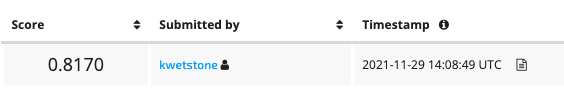

Our submission took about 20 minutes to execute. You can monitor progress during scoring with the Code Execution Status [tab](https://www.drivendata.org/competitions/83/submissions/code/). Finally, we see that we got an IOU of **0.817** - that's pretty good! It means that 81.7% of the area covered by either the ground truth labels or our predictions was shared between the two.

There is still plenty of room for improvement! Head over to the On Cloud N challenge [homepage](https://www.drivendata.org/competitions/83/cloud-cover/page/396/) to get started on your own model. We're excited to see what you create!